In [108]:
import os
import random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def image_read1(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print("Error: Could not read the image.")
        return
    return  img
def image_read(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print("Error: Could not read the image.")
        return

    h, w, _ = img.shape
    crop_x = int(w * 0.15)
    crop_y = int(h * 0.15)

    cropped_img = img[crop_y:h - crop_y, crop_x:w - crop_x]
    return cropped_img

def image_read_grayscale(image_path):
    img = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Error: Could not read the image.")
        return
    return  img


def image_read_hsv(image_path):
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        print("Error: Could not read the image.")
        return None

    # Convert to HSV
    img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

    h, w, _ = img_hsv.shape
    crop_x = int(w * 0.21)
    crop_y = int(h * 0.21)
    cropped_hsv = img_hsv[crop_y:h - crop_y, crop_x:w - crop_x]

    return cropped_hsv


def show_image(matrix,x ,windowName):
    padded_matrix = np.array(matrix, dtype=np.uint8) *x
    print('padded matrix: ', padded_matrix.shape)

    cv2.imshow(windowName, padded_matrix)
    cv2.waitKey(0)
    cv2.destroyWindow(windowName)


def padded_image(img,padd):
    height, width = img.shape[:2]
    if len(img.shape) == 2:
        padded_matrix = np.ones((height + 2 * padd, width + 2 * padd), dtype=np.uint8) * 0
        padded_matrix[padd:padd + height, padd:padd + width] = img
    else:
        channels = img.shape[2]
        padded_matrix = np.ones((height + 2*padd, width + 2*padd,channels), dtype=np.uint8)*0
        padded_matrix[padd:padd+height, padd:padd+width,:] = img
    return padded_matrix


def cal_histogram(img):
    rows,cols=img.shape[:2]
    arr=np.zeros(256,dtype=int)
    arr1=np.zeros(256,dtype=int)
    arr2=np.zeros(256,dtype=int)
    for i in range(rows):
        for j in range(cols):
            b, g, r=img[i][j]
            arr[b]+=1
            arr1[g] += 1
            arr2[r] += 1

    return arr,arr1,arr2

def plot_graph(data, title, xlabel, ylabel, color):
    plt.figure()
    plt.plot(data, color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


def find_root(eq_list, key):
    if key not in eq_list:
        eq_list[key] = key
        return key
    while eq_list[key] != key:
        eq_list[key] = eq_list[eq_list[key]]  # Path compression
        key = eq_list[key]
    return key

def connectivit_8(image,upp_limit,low_limit=0):
    height, width = image.shape[:2]
    connect_8 = np.zeros((height,width), dtype=np.uint16)
    eq_list = {}
    label = 1

    for i in range(1, height):
        for j in range(1, width):
            if image[i, j]>low_limit and image[i,j] <=upp_limit:  # Foreground pixel
                neighbors = []
                if image[i, j - 1]>low_limit and  image[i, j - 1]<=upp_limit:
                    neighbors.append(connect_8[i, j - 1])
                if image[i - 1, j]> low_limit and image[i - 1, j]<=upp_limit:
                    neighbors.append(connect_8[i - 1, j])
                if image[i - 1, j - 1] > low_limit  and image[i - 1, j - 1]<=upp_limit:
                    neighbors.append(connect_8[i - 1, j -1])
                if (j+1)<width and (image[i - 1, j + 1]>low_limit and image[i - 1, j + 1] <=upp_limit):
                    neighbors.append(connect_8[i - 1, j + 1])

                if not neighbors:
                    connect_8[i, j] = label
                    eq_list[label] = label
                    label += 1
                else:
                    min_label = min(neighbors)
                    connect_8[i, j] = min_label
                    for neighbor in neighbors:
                        eq_list[find_root(eq_list, neighbor)] = find_root(eq_list, min_label)

    for i in range(height):
        for j in range(width):
            if connect_8[i, j] > 0:
                connect_8[i, j] = find_root(eq_list, connect_8[i, j])
    """
    unique_labels = set(find_root(eq_list, lbl) for lbl in eq_list.values())
    print("Number of labels:", len(unique_labels))
    print("Equivalence list:", eq_list)
    print(f"Unique Vals: {unique_labels}")
    """
    return connect_8, eq_list


def gauss_filter(size, sigma=1):
    midpoint = size // 2
    val = 0
    frame = np.zeros((size, size), dtype=np.float32)
    for i in range(size):
        for j in range(size):
            x = i - midpoint
            y = j - midpoint
            temp = 1 / (2 * np.pi * sigma ** 2)
            frame[i][j] = (temp * np.exp(-((x ** 2 + y ** 2) / (2 * (sigma ** 2)))))
            val += frame[i][j]
    return frame / val

def apply_gauss(image, size=5, sigma=1):
    frame = gauss_filter(size, sigma)
    rows, cols = image.shape
    output_img = np.zeros((rows, cols), dtype=np.uint8)
    padd_size = size // 2
    padd_img = padded_image(image, padd_size)
    pix_min = np.min(image)
    pix_max = np.max(image)
    for i in range(padd_size, rows + padd_size):
        for j in range(padd_size, cols + padd_size):
            patch= padd_img[i - padd_size:i + padd_size + 1, j - padd_size:j + padd_size + 1]
            new_value=np.sum(np.multiply(patch,frame))
            if pix_max != pix_min:
                normalized_value = int(255 * (new_value - pix_min) / (pix_max - pix_min))
                output_img[i - padd_size, j - padd_size] = normalized_value
            else:
                output_img[i - padd_size, j - padd_size] = int(new_value)
    return output_img


def thresholding(mag_matrix,max_val):
    upperlimit=0.7*max_val
    lowerlimit=0.2*max_val
    rows, cols = mag_matrix.shape[:2]
    matrix = np.zeros((rows,cols), dtype=np.uint8)
    for i in range(0, rows):
        for j in range(0, cols):
            if mag_matrix[i][j] >= upperlimit:
                matrix[i][j] = 1
            elif mag_matrix[i][j] <= lowerlimit:
                matrix[i][j] = 0
            else:
                matrix[i][j]=mag_matrix[i][j]
    return matrix

def color_img(img,x):
    rows,cols=img.shape
    matrix = np.array(img, dtype=np.uint8)
    for i in range(0,rows):
        for j in range (0,cols):
            if img[i][j]>0 :
                matrix[i][j]=x
            else:
                matrix[i][j]=0
    return matrix
# Initialize an empty DataFrame
df_all = pd.DataFrame(columns=["x", "y", "H", "S", "V", "label"])

# Dictionary of image folders and labels
wbc_classes = {
    "Basophil": r"E:\2. DIP\2. LAB\pythonProject\Projects\Assignment 2\wbc_data\Train\Basophil",
    "Eosinophil": r"E:\2. DIP\2. LAB\pythonProject\Projects\Assignment 2\wbc_data\Train\Eosinophil",
    "Lymphocyte": r"E:\2. DIP\2. LAB\pythonProject\Projects\Assignment 2\wbc_data\Train\Lymphocyte",
    "Monocyte": r"E:\2. DIP\2. LAB\pythonProject\Projects\Assignment 2\wbc_data\Train\Monocyte",
    "Neutrophil": r"E:\2. DIP\2. LAB\pythonProject\Projects\Assignment 2\wbc_data\Train\Neutrophil"
}



In [ ]:
df_all = pd.DataFrame()  # Initialize your main DataFrame

image_id = 0  # Start with image ID 0

# Loop through each class
for label, image_dir in wbc_classes.items():
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    selected_images = random.sample(image_files, min(100, len(image_files)))  # Sample 10 or fewer

    for file in selected_images:
        image_path = os.path.join(image_dir, file)
        img_hsv = image_read_hsv(image_path)

        if img_hsv is None:
            continue

        h, s, v = cv2.split(img_hsv)
        img_blur = cv2.medianBlur(s, 7)
        img_gauss = apply_gauss(img_blur, 3, 0.2)
        nuc_img, eq_list = connectivit_8(img_gauss, 255, 140)
        final_mask = color_img(nuc_img, 255)


        ys, xs = np.where(final_mask ==255)
        hsv_values = img_hsv[ys, xs]  # Nucleus HSV pixels

        # Prepare DataFrame for this image
        data = {
            "x": xs,
            "y": ys,
            "H": hsv_values[:, 0],
            "S": hsv_values[:, 1],
            "V": hsv_values[:, 2],
            "label": [label] * len(xs),
            "image_id": [image_id] * len(xs)  # Assign current image ID
        }
        df_image = pd.DataFrame(data)
        df_all = pd.concat([df_all, df_image], ignore_index=True)

        image_id += 1  # Increment image ID for next image

# Inspect result
print(df_all.tail())


In [47]:
df_all.head()

,x,y,H,S,V,label,image_id
0,172,57,139,89,132,Basophil,0.0
1,173,57,140,89,126,Basophil,0.0
2,174,57,140,90,133,Basophil,0.0
3,175,57,140,89,134,Basophil,0.0
4,176,57,139,88,133,Basophil,0.0


In [92]:
# Group by image_id and aggregate all columns
grouped_df = df_all_test.groupby('image_id').agg({
    'x': 'mean',
    'y': 'mean',
    'H': 'mean',
    'S': 'mean',
    'V': 'mean',
    'label': 'first'     # assumes consistent label
}).reset_index()

# Add pixel count
grouped_df['pixel_count'] = df_all_test.groupby('image_id').size().values

# Display
grouped_df.tail()


,image_id,x,y,H,S,V,label,pixel_count
244,245.0,161.453055,169.517704,140.173269,215.571035,88.803222,Neutrophil,13782
245,246.0,170.937534,170.510724,138.857909,219.330831,102.820107,Neutrophil,14920
246,247.0,171.358663,165.030796,140.536411,211.209783,111.469997,Neutrophil,14515
247,248.0,167.117082,174.376913,141.858623,214.371354,105.915380,Neutrophil,14571
248,249.0,170.747985,168.121428,138.447824,220.643265,104.958449,Neutrophil,13646


In [93]:
grouped_df.shape

(249, 8)

In [86]:
full_stats = df_all.groupby("label")[["H", "S", "V", "pixel_count"]].describe()
print("\nFull HSV :\n", full_stats)

KeyError: "Columns not found: 'pixel_count'"

In [39]:
pixel_counts = df_all.groupby(["image_id", "label"]).size().reset_index(name='total_pixels')

(498, 3)

In [43]:
pixel_counts.head()

,image_id,label,total_pixels
0,0.0,Basophil,45160
1,1.0,Basophil,45938
2,2.0,Basophil,39840
3,3.0,Basophil,427
4,4.0,Basophil,39175


In [45]:
stats_by_label = pixel_counts.groupby("label")["total_pixels"].describe()
stats_by_label.head()


,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
Basophil,98.0,41112.979592,13948.456622,36.0,37914.00,43276.0,48915.00,71989.0
Eosinophil,100.0,20442.130000,4631.644638,7134.0,17938.25,19899.0,22085.25,45921.0
Lymphocyte,100.0,18562.840000,4175.732423,9291.0,15841.00,18174.5,20845.00,32471.0
Monocyte,100.0,30012.410000,3780.423233,22666.0,27445.50,29555.5,32396.50,40319.0
Neutrophil,100.0,15652.770000,3417.088819,10106.0,13713.25,15072.0,16591.50,32891.0


In [35]:
full_stats = df_all.groupby("label")[["H", "S", "V"]].agg(["mean", "std", "min", "max"])
print("\nFull HSV :\n", full_stats)


Full HSV Statistics:
                      H                               S                       \
                  mean       std  min  max        mean        std  min  max   
label                                                                         
Basophil    145.919316  6.650920    0  179  156.942083  31.860291   41  255   
Eosinophil  154.214469  5.577209  126  171  194.713787  23.811111  110  255   
Lymphocyte  149.854298  6.177490  115  171  200.540965  23.382442  111  255   
Monocyte    155.243694  4.203981  130  170  184.554893  23.237968  107  255   
Neutrophil  145.828241  7.962733  118  170  204.635984  25.863401  108  255   

                     V                      
                  mean        std min  max  
label                                       
Basophil    129.342184  14.237356  37  235  
Eosinophil  135.932707  20.585251  64  221  
Lymphocyte  121.449391  20.663742  62  206  
Monocyte    143.717005  18.939084  70  234  
Neutrophil  113.104666  18.59

In [65]:
wbc_classes_test = {
    "Basophil": r"E:\2. DIP\2. LAB\pythonProject\Projects\Assignment 2\wbc_data\Test\Basophil",
    "Eosinophil": r"E:\2. DIP\2. LAB\pythonProject\Projects\Assignment 2\wbc_data\Test\Eosinophil",
    "Lymphocyte": r"E:\2. DIP\2. LAB\pythonProject\Projects\Assignment 2\wbc_data\Test\Lymphocyte",
    "Monocyte": r"E:\2. DIP\2. LAB\pythonProject\Projects\Assignment 2\wbc_data\Test\Monocyte",
    "Neutrophil": r"E:\2. DIP\2. LAB\pythonProject\Projects\Assignment 2\wbc_data\Test\Neutrophil"
}

df_all_test = pd.DataFrame()  # Initialize your main DataFrame

image_id = 0  # Start with image ID 0

# Loop through each class
for label, image_dir in wbc_classes_test.items():
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    selected_images = random.sample(image_files, min(100, len(image_files)))  # Sample 10 or fewer

    for file in selected_images:
        image_path = os.path.join(image_dir, file)
        img_hsv = image_read_hsv(image_path)

        if img_hsv is None:
            continue

        h, s, v = cv2.split(img_hsv)
        img_blur = cv2.medianBlur(s, 7)
        img_gauss = apply_gauss(img_blur, 3, 0.2)
        nuc_img, eq_list = connectivit_8(img_gauss, 255, 140)
        final_mask = color_img(nuc_img, 255)


        ys, xs = np.where(final_mask ==255)
        hsv_values = img_hsv[ys, xs]  # Nucleus HSV pixels

        # Prepare DataFrame for this image
        data = {
            "x": xs,
            "y": ys,
            "H": hsv_values[:, 0],
            "S": hsv_values[:, 1],
            "V": hsv_values[:, 2],
            "label": [label] * len(xs),
            "image_id": [image_id] * len(xs)  # Assign current image ID
        }
        df_image = pd.DataFrame(data)
        df_all_test = pd.concat([df_all_test, df_image], ignore_index=True)

        image_id += 1  # Increment image ID for next image

# Inspect result



In [66]:
df_all_test.to_csv("Combined_work_test2.csv", index=False)

In [67]:
df_all_test.tail()

,x,y,H,S,V,label,image_id
6348234,198,254,154,165,147,Neutrophil,249.0
6348235,199,254,153,165,145,Neutrophil,249.0
6348236,200,254,153,161,149,Neutrophil,249.0
6348237,201,254,152,159,148,Neutrophil,249.0
6348238,202,254,152,159,148,Neutrophil,249.0


In [73]:
df_all_test.shape, df_all.shape

((6348239, 7), (12496087, 7))

In [84]:
# Group by image_id and calculate mean of H, S, V
mean_hsv_test = df_all_test.groupby('image_id')[['H', 'S', 'V']].mean().reset_index()
print(mean_hsv_test.shape)
# Display the result
mean_hsv_test.tail()


(249, 4)


,image_id,H,S,V
244,245.0,140.173269,215.571035,88.803222
245,246.0,138.857909,219.330831,102.820107
246,247.0,140.536411,211.209783,111.469997
247,248.0,141.858623,214.371354,105.915380
248,249.0,138.447824,220.643265,104.958449


In [70]:
pixel_counts_test = df_all_test.groupby(["image_id", "label"]).size().reset_index(name='total_pixels_test')
print(pixel_counts_test.shape)
pixel_counts_test.tail()

(249, 3)


,image_id,label,total_pixels_test
244,245.0,Neutrophil,13782
245,246.0,Neutrophil,14920
246,247.0,Neutrophil,14515
247,248.0,Neutrophil,14571
248,249.0,Neutrophil,13646


In [75]:
stats_by_label = pixel_counts_test.groupby("label")["total_pixels_test"].describe()
stats_by_label.head()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
Basophil,49.0,40188.693878,13979.510765,11.0,38819.00,42359.0,46169.00,71898.0
Eosinophil,50.0,21585.620000,3476.163660,14094.0,19367.25,21522.0,23801.75,30412.0
Lymphocyte,50.0,18764.180000,3050.828330,13763.0,16439.00,18791.5,20342.25,27620.0
Monocyte,50.0,31062.740000,5073.125550,15396.0,27817.25,31079.0,34232.00,42569.0
Neutrophil,50.0,16167.320000,2538.045138,12391.0,14529.00,15575.0,17399.00,21792.0


In [82]:
stats_by_label.shape

(5, 8)

In [71]:
full_stats_test = df_all_test.groupby("label")[["H", "S", "V"]].agg(["mean", "std", "min", "max"])
print("\nFull HSV Statistics:\n", full_stats_test)


Full HSV Statistics:
                      H                               S                       \
                  mean       std  min  max        mean        std  min  max   
label                                                                         
Basophil    145.594661  5.386781    0  179  158.087497  30.500108   70  255   
Eosinophil  156.495419  3.809169  135  172  196.452656  20.551506  124  255   
Lymphocyte  150.949546  5.468467  121  169  206.263460  18.798327  122  255   
Monocyte    153.753665  3.774149  134  169  191.080099  19.697619  113  255   
Neutrophil  146.184604  7.058292  127  169  208.527454  22.718490  131  255   

                     V                      
                  mean        std min  max  
label                                       
Basophil    130.121865  13.782441  22  217  
Eosinophil  144.938306  16.818269  76  218  
Lymphocyte  119.827412  18.966651  73  205  
Monocyte    134.409328  19.134072  75  225  
Neutrophil  112.877454  17.93

In [76]:
df_all_test.head()

,x,y,H,S,V,label,image_id
0,125,4,155,116,117,Basophil,0.0
1,126,4,154,125,108,Basophil,0.0
2,127,4,154,131,103,Basophil,0.0
3,128,4,154,117,116,Basophil,0.0
4,129,4,154,113,120,Basophil,0.0


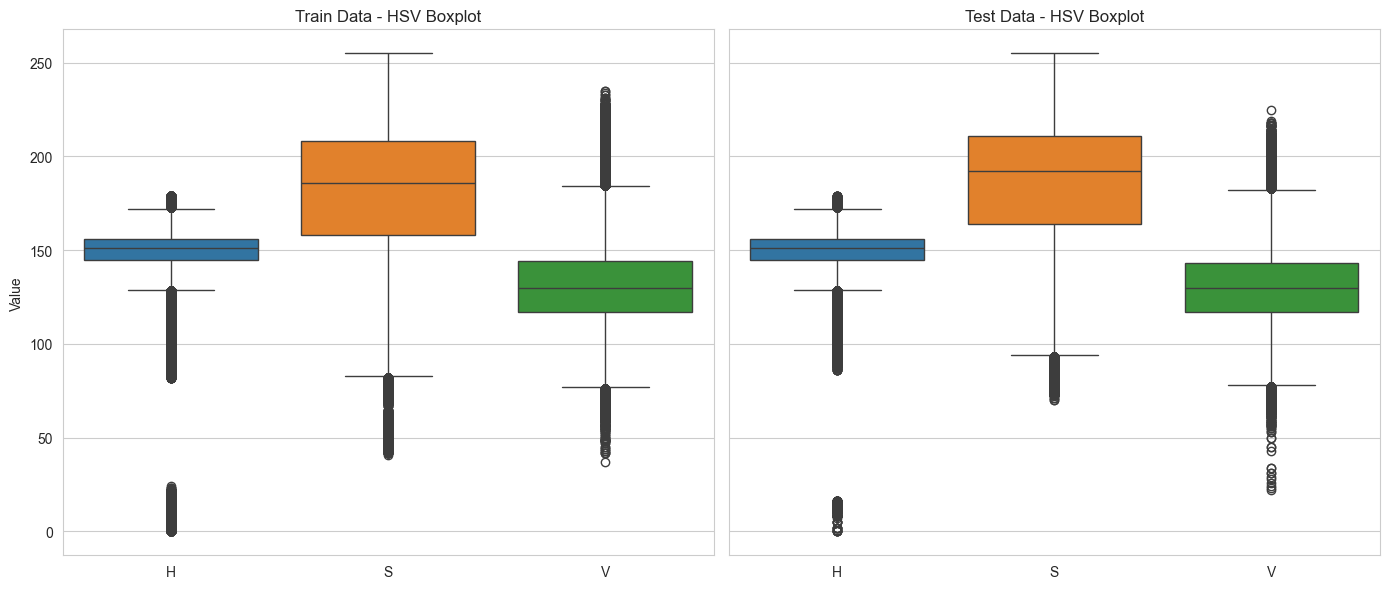

In [79]:
import seaborn as sns

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Boxplot for train data
sns.boxplot(data=df_all[['H', 'S', 'V']], ax=axes[0])
axes[0].set_title('Train Data - HSV Boxplot')
axes[0].set_ylabel('Value')

# Boxplot for test data
sns.boxplot(data=df_all_test[['H', 'S', 'V']], ax=axes[1])
axes[1].set_title('Test Data - HSV Boxplot')

plt.tight_layout()
plt.show()


In [100]:
# Group by image_id and aggregate all columns
grouped_df = df_all.groupby('image_id').agg({
    'x': 'mean',
    'y': 'mean',
    'H': 'mean',
    'S': 'mean',
    'V': 'mean',
    'label': 'first'     # assumes consistent label
}).reset_index()

# Add pixel count
grouped_df['pixel_count'] = df_all.groupby('image_id').size().values


grouped_df.tail()


,image_id,x,y,H,S,V,label,pixel_count
493,495.0,172.318524,181.265544,154.142048,205.852446,115.389949,Neutrophil,18705
494,496.0,165.391854,174.242459,134.025135,213.816770,119.691673,Neutrophil,15516
495,497.0,162.111969,171.063763,149.035990,203.083155,110.763517,Neutrophil,18255
496,498.0,168.754106,167.150703,142.839600,218.518801,88.995646,Neutrophil,10106
497,499.0,169.391948,173.192868,154.349540,199.268942,133.599847,Neutrophil,13040


In [104]:
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

# Columns to check for outliers
cols_to_check = ['H', 'S', 'V', 'pixel_count']

# Remove outliers
grouped_df_filtered = remove_outliers_iqr(grouped_df, cols_to_check)

print(grouped_df_filtered.shape)
# Show result
grouped_df_filtered.tail()


(456, 8)


,image_id,x,y,H,S,V,label,pixel_count
493,495.0,172.318524,181.265544,154.142048,205.852446,115.389949,Neutrophil,18705
494,496.0,165.391854,174.242459,134.025135,213.816770,119.691673,Neutrophil,15516
495,497.0,162.111969,171.063763,149.035990,203.083155,110.763517,Neutrophil,18255
496,498.0,168.754106,167.150703,142.839600,218.518801,88.995646,Neutrophil,10106
497,499.0,169.391948,173.192868,154.349540,199.268942,133.599847,Neutrophil,13040


In [105]:
mean_hsv_train = grouped_df_filtered.groupby('label')[['H', 'S', 'V', 'pixel_count']].mean().reset_index()
print(mean_hsv_test.shape)
print(mean_hsv_train.head())

(498, 3)
        label           H           S           V   pixel_count
0    Basophil  145.582703  169.303281  128.731900  39753.220339
1  Eosinophil  153.886090  196.164931  134.662286  20362.909091
2  Lymphocyte  149.463219  202.225906  119.699849  18654.545455
3    Monocyte  155.298779  184.882364  143.860839  30012.410000
4  Neutrophil  145.770538  205.781602  112.298198  15692.494949


In [106]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import euclidean

# Step 1: Feature vectors for each class
class_vectors = grouped_df_filtered.groupby('label')[['H', 'S', 'V', 'pixel_count']].mean()

# Step 2: Group test images
test_features = df_all_test.groupby('image_id').agg({
    'H': 'mean',
    'S': 'mean',
    'V': 'mean',
    'x': 'count',
    'label': 'first'
}).reset_index()
test_features.rename(columns={'x': 'pixel_count'}, inplace=True)

# Step 3: Predict label for each test image
def predict_label(row):
    input_vector = row[['H', 'S', 'V', 'pixel_count']].values
    distances = class_vectors.apply(lambda x: euclidean(input_vector, x), axis=1)
    return distances.idxmin()

test_features['predicted'] = test_features.apply(predict_label, axis=1)

# Step 4: Accuracy
accuracy = accuracy_score(test_features['label'], test_features['predicted'])

# Step 5: Result DataFrame and Accuracy
result_df = test_features[['image_id', 'label', 'predicted']]
print("Accuracy:", accuracy)
result_df.head()


Accuracy: 0.6184738955823293


,image_id,label,predicted
0,0.0,Basophil,Basophil
1,1.0,Basophil,Basophil
2,2.0,Basophil,Basophil
3,3.0,Basophil,Basophil
4,4.0,Basophil,Basophil


In [102]:
# Group by image_id and aggregate all columns
grouped_df_test = df_all_test.groupby('image_id').agg({
    'x': 'mean',
    'y': 'mean',
    'H': 'mean',
    'S': 'mean',
    'V': 'mean',
    'label': 'first'     # assumes consistent label
}).reset_index()

# Add pixel count
grouped_df_test['pixel_count'] = df_all_test.groupby('image_id').size().values
print(grouped_df_test.shape)
# Display
grouped_df_test.sample(10)


(249, 8)


,image_id,x,y,H,S,V,label,pixel_count
107,108.0,166.118028,168.416939,143.317787,213.168432,110.990963,Lymphocyte,19919
86,87.0,176.774643,178.067413,156.349343,191.741618,140.592900,Eosinophil,27858
45,46.0,145.263378,170.984576,145.465137,180.959749,139.376288,Basophil,37862
234,235.0,160.660661,167.326862,154.865689,206.596974,139.256331,Neutrophil,21480
133,134.0,167.933341,173.766039,144.425173,214.088779,106.830551,Lymphocyte,16772
125,126.0,169.201409,169.167889,154.200076,205.328921,131.915913,Lymphocyte,21002
83,84.0,159.440611,158.239630,158.481335,193.322634,162.536718,Eosinophil,21216
117,118.0,169.482585,171.432039,147.844594,209.568798,100.133736,Lymphocyte,21505
46,47.0,176.888523,177.335210,145.811403,159.338825,138.288394,Basophil,52567
130,131.0,164.909213,169.453224,153.143048,199.479176,139.801035,Lymphocyte,22426


In [107]:
grouped_df_test.sample(10)

,image_id,x,y,H,S,V,label,pixel_count
7,8.0,186.570576,161.291133,144.228628,189.629399,132.153488,Basophil,40205
43,44.0,193.389969,179.218211,143.717436,193.827891,131.466798,Basophil,39998
148,149.0,165.137515,169.602728,151.766388,211.245553,113.508768,Lymphocyte,15911
206,207.0,156.170741,160.411340,152.636909,203.553893,125.161259,Neutrophil,15503
70,71.0,164.872162,172.954164,159.181101,199.447762,151.138243,Eosinophil,25853
17,18.0,159.694232,163.280652,148.043191,161.824035,142.416063,Basophil,39059
79,80.0,156.382155,184.870017,157.502394,194.913825,150.928865,Eosinophil,23603
224,225.0,173.283397,167.637811,143.439486,209.542797,110.696793,Neutrophil,13377
95,96.0,174.102646,238.276322,156.098725,186.249825,158.146808,Eosinophil,24229
89,90.0,165.424700,157.307751,156.993047,201.569550,143.054062,Eosinophil,22437
